# Analyzing neighborhoods and beer consume by students in the vicinity of University of São Paulo in São Paulo/ Brazil to start a Pub & Beer Store.

## INTRODUCTION

    Beer is the second most consumed alcoholic beverage in the world and the most consumed in Brazil ¹. In this country the consumption percentage of beer falls in approximately 60% and the Brazilians are the third in consuming this fresh and bubbling drink and presenting growth in this habit ². The city of São Paulo is the biggest one in all South America and have 12.33 million habitants and data available about this theme and in that population center inside University of São Paulo, USP, is available on Kaggle³. In that city exist a borough called Butantã and there is located the USP, the better college in all South America and one of the biggest campus in all the state. Also the total revenue for Brazil in 2021 was predicted to be 51,160 million dollars and the average per capita for the same year to be 239.07 dollars 4. So the intention in this report is to justify the best time and place to open a Pub & Beer Store using the Foursquare API and create a model to evaluate a tendency in the consumption of beer through time in the same city and what's the best variables to use in that model. The final goal is to obtain the best profitable place in the Butanta's borough in São Paulo and knowing the consumer behavior through a dataset will create an opportunity to ensure bigger sales and better brand  exposure.

## METHODOLOGY

### Data Collection

Data about the consume of beer by USP students was collect from Kaggle. Geopositional coordinates from the neighborhoods around the college campus was obtained with Google maps and with Foursquare API we could extract data contain venues information in a certain radius from the campus. 

### Import the necessary libraries

In [369]:
# creates a map based on geographic coordinates
import folium
# requests is an elegant and simple HTTP library for Python
import requests
import urllib3
# used for data manipulation 
import pandas as pd
# used for creation and manipulation of arrays
import numpy as np
# for metrics like R² and R² ajusted
import statsmodels.api as sm
# create graphs and other kinds of plots
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
%matplotlib inline
import seaborn as sns
# visualize images with Python
from IPython.display import Image
# find geographic coordinates based only in the name and state of places
from geopy.geocoders import Nominatim
# normalize semi-structured JSON data into a flat table
from pandas.io.json import json_normalize
# standardize features by removing the mean and scaling to unit variance
from sklearn.preprocessing import StandardScaler
# split the dataset into train and test 
from sklearn.model_selection import train_test_split
# generates a statistical unsupervised model based on DBSCAN clustering 
from sklearn.cluster import KMeans
# generates a statistical supervised model based on linear regression  
from sklearn.linear_model import LinearRegression
# get the metrics for a linear regression model and for a clustering one, respectively
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import silhouette_score

### Data retrieval and wrangling


Define the Foursquare API credentials, version, limit of venues and search radius

In [569]:
CLIENT_ID = 'XZ1333IVIYQ2BEKPLJ04HWW0KBS1IHLB00DOMZOIGFIKJ3XA'
CLIENT_SECRET = 'IU55IEWT04PH12E1DZ05BHJYPOEKKY5IBGOLGCFQSJ0NW0XL'
VERSION = '20210131'
# limit of number of venues returned by Foursquare API
LIMIT = 500 
radius = 3000

Create a Dataframe with geospatial information about the neighborhood

In [570]:
long_lat_butanta_neighborhood = {'Neighborhood':['Butantã','Jaguaré','Alto Pinheiros','Torres de Oliveira','Jardim Everest',
                                                 'Jardim Bonfiglioli','Rio Pequeno'],
                                 'Latitude':[-23.5608,-23.5448,-23.5508,-23.5496,-23.5750,-23.5803,-23.5638],
                                 'Longitude':[-46.7266,-46.7468,-46.7072,-46.7369,-46.7053,-46.7395,-46.7535]} 
long_lat_neighborhood = pd.DataFrame(data=long_lat_butanta_neighborhood)
long_lat_neighborhood[['Latitude','Longitude']] = long_lat_neighborhood[['Latitude','Longitude']].astype(float) 
long_lat_neighborhood

,Neighborhood,Latitude,Longitude
0,Butantã,-23.5608,-46.7266
1,Jaguaré,-23.5448,-46.7468
2,Alto Pinheiros,-23.5508,-46.7072
3,Torres de Oliveira,-23.5496,-46.7369
4,Jardim Everest,-23.5750,-46.7053
5,Jardim Bonfiglioli,-23.5803,-46.7395
6,Rio Pequeno,-23.5638,-46.7535


In [571]:
# To be used in folium API
latitude = -23.5608
longitude = -46.7266

In [572]:
# Select first building:
neighborhood_name = long_lat_neighborhood.loc[0, 'Neighborhood']
neighborhood_lat = long_lat_neighborhood.loc[0, 'Latitude']
neighborhood_long = long_lat_neighborhood.loc[0, 'Longitude'] 

Define the url and send the get request to FourSquare API

In [573]:
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_lat, 
    neighborhood_long, 
    radius, 
    LIMIT)

In [574]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '601d72e3ddc793587728ba93'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'São Paulo',
  'headerFullLocation': 'São Paulo',
  'headerLocationGranularity': 'city',
  'totalResults': 209,
  'suggestedBounds': {'ne': {'lat': -23.533799972999972,
    'lng': -46.69719945008936},
   'sw': {'lat': -23.58780002700003, 'lng': -46.75600054991064}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4e01125322717718d39f5e9d',
       'name': 'Run and Fun',
       'location': {'address': 'Prç. da Reitoria, 41-83',
        'crossStreet': 'R. da Reitoria, s/n',
        'lat': -23.561661223013395,
        'lng': -46.72143358616759,
        'labeledLatLngs': [{'la

Get the part that's of our interest from the json file

We will now create a function get_category_type to extract the categories of venues.

In [575]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we can clean the JSON obtained using the GET method and store our results in a dataframe.

In [576]:
# Its important to remember that only the search radius parting from the center of the USP campus is the focus in this project.
# Because of that matter, we will not generalize the search
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

<ipython-input-576-b47a32e619ce>:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  nearby_venues = json_normalize(venues) # flatten JSON


,name,categories,lat,lng
0,Run and Fun,Track,-23.561661,-46.721434
1,Corre Brasil Assessoria Esportiva,Gym / Fitness Center,-23.559369,-46.721927
2,Biblioteca Brasiliana Guita e José Mindlin,Library,-23.562230,-46.721805
3,Instituto Butantan,Science Museum,-23.566442,-46.718731
4,Centro de Práticas Esportivas da Universidade ...,College Gym,-23.561660,-46.716815


#### Explore the Neighborhood of Butantã in São Paulo 

In [577]:
# Let's see how much venues we have in the search radius in the Foursquare 
print("{} venues were returned for {} by Foursquare".format(len(nearby_venues), neighborhood_name))

100 venues were returned for Butantã by Foursquare


#### Let's create a function to repeat the same process to all the neighborhood of Butantã in São Paulo

In [578]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

The code bellow uses the above function on each neighborhood and create a new dataframe called butanta_venues.

In [579]:
butanta_venues = getNearbyVenues(names=long_lat_neighborhood['Neighborhood'], 
                                 latitudes=long_lat_neighborhood['Latitude'], 
                                 longitudes=long_lat_neighborhood['Longitude'])

Butantã
Jaguaré
Alto Pinheiros
Torres de Oliveira
Jardim Everest
Jardim Bonfiglioli
Rio Pequeno


Let's check the size of the resulting dataframe

In [580]:
print(butanta_venues.shape)
butanta_venues.head()

(140, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Butantã,-23.5608,-46.7266,Praça do Relógio,-23.560188,-46.722819,Plaza
1,Butantã,-23.5608,-46.7266,Copiadora da Letras (FFLCH/USP),-23.561926,-46.725819,Paper / Office Supplies Store
2,Butantã,-23.5608,-46.7266,Lanchonete da Letras (FFLCH/USP),-23.561760,-46.725777,College Cafeteria
3,Butantã,-23.5608,-46.7266,Sweden Restaurante,-23.557785,-46.728474,Restaurant
4,Butantã,-23.5608,-46.7266,Lanchone Carlicea (Dona Hermínia),-23.558300,-46.726394,Snack Place


In [581]:
butanta_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Alto Pinheiros,16,16,16,16,16,16
Butantã,7,7,7,7,7,7
Jaguaré,12,12,12,12,12,12
Jardim Bonfiglioli,35,35,35,35,35,35
Jardim Everest,45,45,45,45,45,45
Rio Pequeno,12,12,12,12,12,12
Torres de Oliveira,13,13,13,13,13,13


In [582]:
print('There are {} uniques categories.'.format(len(butanta_venues['Venue Category'].unique())))

There are 68 uniques categories.


Analyze Each Neighborhood

In [583]:
# one hot encoding
butanta_onehot = pd.get_dummies(butanta_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
butanta_onehot['Neighborhood'] = butanta_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [butanta_onehot.columns[-1]] + list(butanta_onehot.columns[:-1])
butanta_onehot = butanta_onehot[fixed_columns]

butanta_onehot.head()

,Neighborhood,Art Gallery,Asian Restaurant,Bakery,Bar,Beer Bar,Beer Store,Bike Rental / Bike Share,Brazilian Restaurant,Brewery,...,Southeastern Brazilian Restaurant,Spa,Sports Club,Stables,Steakhouse,Supermarket,Sushi Restaurant,Thai Restaurant,Veterinarian,Yoga Studio
0,Butantã,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Butantã,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Butantã,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Butantã,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Butantã,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category


In [584]:
butanta_grouped = butanta_onehot.groupby('Neighborhood').mean().reset_index()
butanta_grouped

,Neighborhood,Art Gallery,Asian Restaurant,Bakery,Bar,Beer Bar,Beer Store,Bike Rental / Bike Share,Brazilian Restaurant,Brewery,...,Southeastern Brazilian Restaurant,Spa,Sports Club,Stables,Steakhouse,Supermarket,Sushi Restaurant,Thai Restaurant,Veterinarian,Yoga Studio
0,Alto Pinheiros,0.000000,0.000000,0.000000,0.062500,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.062500,0.000000,0.000000,0.000000,0.000000
1,Butantã,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Jaguaré,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000
3,Jardim Bonfiglioli,0.000000,0.000000,0.114286,0.028571,0.028571,0.028571,0.000000,0.028571,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.028571,0.028571,0.000000,0.028571,0.028571
4,Jardim Everest,0.022222,0.022222,0.000000,0.022222,0.044444,0.000000,0.022222,0.066667,0.022222,...,0.022222,0.022222,0.022222,0.022222,0.022222,0.000000,0.000000,0.022222,0.000000,0.000000
5,Rio Pequeno,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.083333,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Torres de Oliveira,0.000000,0.000000,0.000000,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Let's print each neighborhood along with the top 5 most common venues

In [585]:
num_top_venues = 20

for hood in butanta_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = butanta_grouped[butanta_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Alto Pinheiros----
                            venue  freq
0               Convenience Store  0.19
1                           Plaza  0.19
2                          Market  0.06
3                     Flower Shop  0.06
4                      Restaurant  0.06
5            Fast Food Restaurant  0.06
6                            Café  0.06
7                     Supermarket  0.06
8            Gym / Fitness Center  0.06
9                     IT Services  0.06
10                            Bar  0.06
11                       Pharmacy  0.06
12                 Ice Cream Shop  0.00
13            Japanese Restaurant  0.00
14            Martial Arts School  0.00
15                    Music Venue  0.00
16                      Nightclub  0.00
17                   Optical Shop  0.00
18  Paper / Office Supplies Store  0.00
19                           Park  0.00


----Butantã----
                            venue  freq
0                     Snack Place  0.29
1                      Food Truck  0.14

From the above analisys, the venues that could represent a concurrence to a Pub & Beer Store in the select boroughs are: Plaza, Fast Food Restaurant, Bar, Food Truck, Restaurant, Snack Place, Brazilian Restaurant, Japanese Restaurant, Burger Joint, Gourmet Shop, Sushi Restaurant, Beer Bar, Ramen Restaurant, Asian Restaurant, Food & Drink Shop, Diner, Nightclub and Churrascaria. All this locations can sell beer and side dishes. 

In [586]:
places = ['Plaza', 'Fast Food Restaurant', 'Bar', 'Food Truck', 'Restaurant', 'Snack Place', 'Brazilian Restaurant',
          'Japanese Restaurant', 'Burger Joint', 'Gourmet Shop', 'Sushi Restaurant', 'Beer Bar', 'Ramen Restaurant',
          'Asian Restaurant', 'Food & Drink Shop', 'Diner', 'Nightclub', 'Churrascaria']
beer_seeling_places = butanta_venues.loc[butanta_venues['Venue Category'].isin(places)]
beer_seeling_places.reset_index(inplace=True, drop=True)
beer_seeling_places.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Butantã,-23.5608,-46.7266,Praça do Relógio,-23.560188,-46.722819,Plaza
1,Butantã,-23.5608,-46.7266,Sweden Restaurante,-23.557785,-46.728474,Restaurant
2,Butantã,-23.5608,-46.7266,Lanchone Carlicea (Dona Hermínia),-23.558300,-46.726394,Snack Place
3,Butantã,-23.5608,-46.7266,Lanchonete da Cênicas,-23.557775,-46.724396,Snack Place
4,Butantã,-23.5608,-46.7266,Kombi do Zé do Coco,-23.560558,-46.722526,Food Truck


In [587]:
# one hot encoding
butanta_onehot = pd.get_dummies(butanta_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
butanta_onehot['Neighborhood'] = butanta_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [butanta_onehot.columns[-1]] + list(butanta_onehot.columns[:-1])
butanta_onehot = butanta_onehot[fixed_columns]

butanta_onehot.head()

,Neighborhood,Art Gallery,Asian Restaurant,Bakery,Bar,Beer Bar,Beer Store,Bike Rental / Bike Share,Brazilian Restaurant,Brewery,...,Southeastern Brazilian Restaurant,Spa,Sports Club,Stables,Steakhouse,Supermarket,Sushi Restaurant,Thai Restaurant,Veterinarian,Yoga Studio
0,Butantã,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Butantã,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Butantã,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Butantã,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Butantã,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [588]:
butanta_grouped = butanta_onehot.groupby('Neighborhood').mean().reset_index()
butanta_grouped

,Neighborhood,Art Gallery,Asian Restaurant,Bakery,Bar,Beer Bar,Beer Store,Bike Rental / Bike Share,Brazilian Restaurant,Brewery,...,Southeastern Brazilian Restaurant,Spa,Sports Club,Stables,Steakhouse,Supermarket,Sushi Restaurant,Thai Restaurant,Veterinarian,Yoga Studio
0,Alto Pinheiros,0.000000,0.000000,0.000000,0.062500,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.062500,0.000000,0.000000,0.000000,0.000000
1,Butantã,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Jaguaré,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000
3,Jardim Bonfiglioli,0.000000,0.000000,0.114286,0.028571,0.028571,0.028571,0.000000,0.028571,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.028571,0.028571,0.000000,0.028571,0.028571
4,Jardim Everest,0.022222,0.022222,0.000000,0.022222,0.044444,0.000000,0.022222,0.066667,0.022222,...,0.022222,0.022222,0.022222,0.022222,0.022222,0.000000,0.000000,0.022222,0.000000,0.000000
5,Rio Pequeno,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.083333,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Torres de Oliveira,0.000000,0.000000,0.000000,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


#### Let's put that into a _pandas_ dataframe

First, let's write a function to sort the venues in descending order.

In [589]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [590]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = butanta_grouped['Neighborhood']

for ind in np.arange(butanta_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(beer_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alto Pinheiros,Plaza,Fast Food Restaurant,Restaurant,Bar,Sushi Restaurant,Beer Bar,Brazilian Restaurant,Burger Joint,Churrascaria,Diner
1,Butantã,Restaurant,Plaza,Food Truck,Snack Place,Sushi Restaurant,Diner,Bar,Beer Bar,Brazilian Restaurant,Burger Joint
2,Jaguaré,Brazilian Restaurant,Japanese Restaurant,Sushi Restaurant,Fast Food Restaurant,Bar,Beer Bar,Burger Joint,Churrascaria,Diner,Food & Drink Shop
3,Jardim Bonfiglioli,Japanese Restaurant,Burger Joint,Sushi Restaurant,Restaurant,Bar,Brazilian Restaurant,Gourmet Shop,Diner,Beer Bar,Churrascaria
4,Jardim Everest,Restaurant,Brazilian Restaurant,Plaza,Beer Bar,Food Truck,Fast Food Restaurant,Asian Restaurant,Ramen Restaurant,Bar,Burger Joint


### Cluster Neighborhoods

Now we need to use KMeans clustering method.

But first find the best number of clusters.

In [591]:
maximum_k = butanta_grouped.shape[0]
scores = []
k_value = []

for k in range(2, maximum_k):
    butanta_grouped_clustering = butanta_grouped.drop('Neighborhood', axis=1)
    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=0)
    KM = kmeans.fit_predict(beer_grouped_clustering)     
    score = silhouette_score(beer_grouped_clustering, KM, random_state=0)
    k_value.append(k)
    scores.append(score)

In [592]:
print(scores)
print(k)
# The best value for k was 2.

[0.2741257777177824, 0.1021371985024523, 0.05360082942330007, 0.05406736706241034, 0.002827676533507364]
6


Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [593]:
# set number of clusters
kclusters = 2

butanta_grouped_clustering = butanta_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(butanta_grouped_clustering)
# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 1, 0, 0, 0, 0, 0])

In [594]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

butanta_merged = long_lat_neighborhood

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
butanta_merged = butanta_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

butanta_merged.head() # check the last columns!

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Butantã,-23.5608,-46.7266,1,Restaurant,Plaza,Food Truck,Snack Place,Sushi Restaurant,Diner,Bar,Beer Bar,Brazilian Restaurant,Burger Joint
1,Jaguaré,-23.5448,-46.7468,0,Brazilian Restaurant,Japanese Restaurant,Sushi Restaurant,Fast Food Restaurant,Bar,Beer Bar,Burger Joint,Churrascaria,Diner,Food & Drink Shop
2,Alto Pinheiros,-23.5508,-46.7072,0,Plaza,Fast Food Restaurant,Restaurant,Bar,Sushi Restaurant,Beer Bar,Brazilian Restaurant,Burger Joint,Churrascaria,Diner
3,Torres de Oliveira,-23.5496,-46.7369,0,Restaurant,Bar,Nightclub,Food Truck,Snack Place,Churrascaria,Sushi Restaurant,Diner,Beer Bar,Brazilian Restaurant
4,Jardim Everest,-23.5750,-46.7053,0,Restaurant,Brazilian Restaurant,Plaza,Beer Bar,Food Truck,Fast Food Restaurant,Asian Restaurant,Ramen Restaurant,Bar,Burger Joint


### Data Visualization

Finally, let's visualize the resulting clusters

In [595]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(butanta_merged['Latitude'], butanta_merged['Longitude'], butanta_merged['Neighborhood'], 
                                  butanta_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### To get a better understanding about the venues in the neighbourhood that interest us let's check the total venue positions with folium. 

In [596]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=13)
# add a red circle marker to represent the center of University of São Paulo campus Butantã
folium.features.CircleMarker(
    [neighborhood_lat, neighborhood_long],
    radius=10,
    color='red',
    popup='USP Butantã',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)
# add all venues as blue circle markers
for lat, lng, label in zip(butanta_venues['Venue Latitude'], butanta_venues['Venue Longitude'], butanta_venues['Venue Category']):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)
venues_map

In the above map we can see that in the college proximity there are several venues, but there are no venues allowed to sell any alcoholic beverages inside the campus, because there are rules applied to that public university. So the focus is to find the best place to install a pub & beer store without concurrence and in proximity to high circulation of people through all the day.

In [597]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=13)
# add a red circle marker to represent the center of University of São Paulo campus Butantã
folium.features.CircleMarker(
    [neighborhood_lat, neighborhood_long],
    radius=10,
    color='red',
    popup='USP Butantã',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)
# add all venues that could sell beer as blue circle markers
for lat, lng, label in zip(beer_seeling_places['Venue Latitude'], beer_seeling_places['Venue Longitude'], 
                           beer_seeling_places['Venue Category']):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)
venues_map

The map above showed us that the borough with less places selling beer are located in the Rio Pequeno vicinities. So there could be a lesser expensive place to set a business based on selling beer to people from the college campus.

## Now lets analise the beer comsumption inside the USP campus

### Data retrieval and wrangling

In [258]:
sp_beer = pd.read_csv('beer_consume.csv', decimal=',')
sp_beer.head()

,Data,Temperatura Media (C),Temperatura Minima (C),Temperatura Maxima (C),Precipitacao (mm),Final de Semana,Consumo de cerveja (litros)
0,2015-01-01,27.30,23.9,32.5,0.0,0.0,25.461
1,2015-01-02,27.02,24.5,33.5,0.0,0.0,28.972
2,2015-01-03,24.82,22.4,29.9,0.0,1.0,30.814
3,2015-01-04,23.98,21.5,28.6,1.2,1.0,29.799
4,2015-01-05,23.82,21.0,28.3,0.0,0.0,28.900


Rename the columns to english for better understanding

In [259]:
sp_beer.rename(columns={'Data':'Date','Temperatura Media (C)':'Average Temperature (C)','Temperatura Minima (C)':'Min Temperature (C)',
                        'Temperatura Maxima (C)':'Max Temperature (C)', 'Precipitacao (mm)':'Precipitacion(mm)', 
                        'Final de Semana':'Weekend','Consumo de cerveja (litros)':'Beer consumed (liters)'}, inplace=True)

See some characteristics from the Dataframe 

In [260]:
sp_beer.shape # the dataframe as 941 rows

(941, 7)

In [261]:
sp_beer.info() # display information about the dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 941 entries, 0 to 940
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Date                     365 non-null    object 
 1   Average Temperature (C)  365 non-null    float64
 2   Min Temperature (C)      365 non-null    float64
 3   Max Temperature (C)      365 non-null    float64
 4   Precipitacion(mm)        365 non-null    float64
 5   Weekend                  365 non-null    float64
 6   Beer consumed (liters)   365 non-null    object 
dtypes: float64(5), object(2)
memory usage: 51.6+ KB


In [274]:
# change the Beer consumed (liters) variable to float
sp_beer['Beer consumed (liters)'] = sp_beer['Beer consumed (liters)'].astype('float')
sp_beer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 365 entries, 0 to 364
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Date                     365 non-null    datetime64[ns]
 1   Average Temperature (C)  365 non-null    float64       
 2   Min Temperature (C)      365 non-null    float64       
 3   Max Temperature (C)      365 non-null    float64       
 4   Precipitacion(mm)        365 non-null    float64       
 5   Weekend                  365 non-null    float64       
 6   Beer consumed (liters)   365 non-null    float64       
 7   Day of Week              365 non-null    object        
 8   Month                    365 non-null    int64         
dtypes: datetime64[ns](1), float64(6), int64(1), object(1)
memory usage: 28.5+ KB


In [262]:
sp_beer.describe(include='all') # wee have the data collected from every day in an entire year (2015) but the same as 
# NaN fill rows so wee need the analyse that 

,Date,Average Temperature (C),Min Temperature (C),Max Temperature (C),Precipitacion(mm),Weekend,Beer consumed (liters)
count,365,365.000000,365.000000,365.000000,365.000000,365.000000,365
unique,365,NaN,NaN,NaN,NaN,NaN,359
top,2015-01-03,NaN,NaN,NaN,NaN,NaN,24.862
freq,1,NaN,NaN,NaN,NaN,NaN,3
mean,NaN,21.226356,17.461370,26.611507,5.196712,0.284932,NaN
std,NaN,3.180108,2.826185,4.317366,12.417844,0.452001,NaN
min,NaN,12.900000,10.600000,14.500000,0.000000,0.000000,NaN
25%,NaN,19.020000,15.300000,23.800000,0.000000,0.000000,NaN
50%,NaN,21.380000,17.900000,26.900000,0.000000,0.000000,NaN
75%,NaN,23.280000,19.600000,29.400000,3.200000,1.000000,NaN


In [263]:
print(sp_beer['Date'].isna().values.any())
print(sp_beer['Average Temperature (C)'].isna().values.any())
print(sp_beer['Min Temperature (C)'].isna().values.any())
print(sp_beer['Max Temperature (C)'].isna().values.any())
print(sp_beer['Precipitacion(mm)'].isna().values.any())
print(sp_beer['Weekend'].isna().values.any())
print(sp_beer['Beer consumed (liters)'].isna().values.any())
# Every column as NaN values 

True
True
True
True
True
True
True


In [264]:
sp_beer.dropna(inplace=True) # Dropping the NaN values 

In [265]:
sp_beer.shape # Now the df as exactly the number of rows as the days of the 2015 year

(365, 7)

In [266]:
print(sp_beer['Date'].isna().values.any())
print(sp_beer['Average Temperature (C)'].isna().values.any())
print(sp_beer['Min Temperature (C)'].isna().values.any())
print(sp_beer['Max Temperature (C)'].isna().values.any())
print(sp_beer['Precipitacion(mm)'].isna().values.any())
print(sp_beer['Weekend'].isna().values.any())
print(sp_beer['Beer consumed (liters)'].isna().values.any())
# Now the df doesn't have any NaN fill row

False
False
False
False
False
False
False


In [267]:
print(sp_beer['Date'].isnull().values.any())
print(sp_beer['Average Temperature (C)'].isnull().values.any())
print(sp_beer['Min Temperature (C)'].isnull().values.any())
print(sp_beer['Max Temperature (C)'].isnull().values.any())
print(sp_beer['Precipitacion(mm)'].isnull().values.any())
print(sp_beer['Weekend'].isnull().values.any())
print(sp_beer['Beer consumed (liters)'].isnull().values.any())
# Neither any null number

False
False
False
False
False
False
False


In [268]:
# df as a weekend column, but the date column doesn't as any use, unless transformed to a day of week 
import calendar

sp_beer['Date'] = sp_beer['Date'].apply(pd.to_datetime)
sp_beer['Day of Week'] = sp_beer['Date'].apply(lambda x: x.weekday())

days = {}
for i,v in enumerate(list(calendar.day_name)):
    days[i]=v
    
days_name = np.array([])
for i in sp_beer['Day of Week']:
    for j in range(0,len(days)):
        if i == list(days.keys())[j]:
            days_name = np.append(days_name,days[j])

sp_beer['Day of Week'] = days_name 

sp_beer.head()

,Date,Average Temperature (C),Min Temperature (C),Max Temperature (C),Precipitacion(mm),Weekend,Beer consumed (liters),Day of Week
0,2015-01-01,27.30,23.9,32.5,0.0,0.0,25.461,Thursday
1,2015-01-02,27.02,24.5,33.5,0.0,0.0,28.972,Friday
2,2015-01-03,24.82,22.4,29.9,0.0,1.0,30.814,Saturday
3,2015-01-04,23.98,21.5,28.6,1.2,1.0,29.799,Sunday
4,2015-01-05,23.82,21.0,28.3,0.0,0.0,28.900,Monday


In [269]:
sp_beer['Month'] = pd.DatetimeIndex(sp_beer['Date']).month
sp_beer.head()

,Date,Average Temperature (C),Min Temperature (C),Max Temperature (C),Precipitacion(mm),Weekend,Beer consumed (liters),Day of Week,Month
0,2015-01-01,27.30,23.9,32.5,0.0,0.0,25.461,Thursday,1
1,2015-01-02,27.02,24.5,33.5,0.0,0.0,28.972,Friday,1
2,2015-01-03,24.82,22.4,29.9,0.0,1.0,30.814,Saturday,1
3,2015-01-04,23.98,21.5,28.6,1.2,1.0,29.799,Sunday,1
4,2015-01-05,23.82,21.0,28.3,0.0,0.0,28.900,Monday,1


### Data Visualization

Now lets see some graphs to better understand the variables correlation

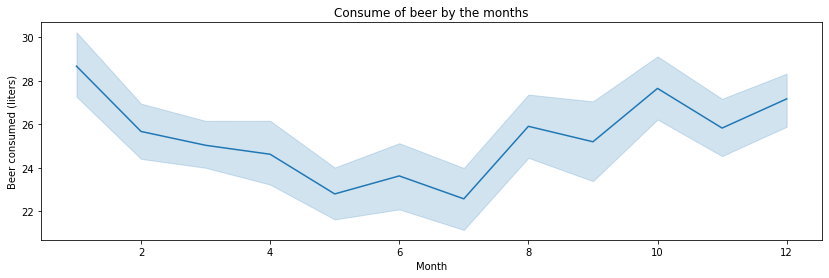

In [604]:
plt.figure(figsize=(14, 4))
sns.lineplot(x=sp_beer['Month'], y=sp_beer['Beer consumed (liters)'], palette="pastel")
plt.title('Consume of beer by the months')
plt.show()
# here we can see that in the january has the greatest consume of beer by the students 
# so in a weekend in that month whe should have better sales 

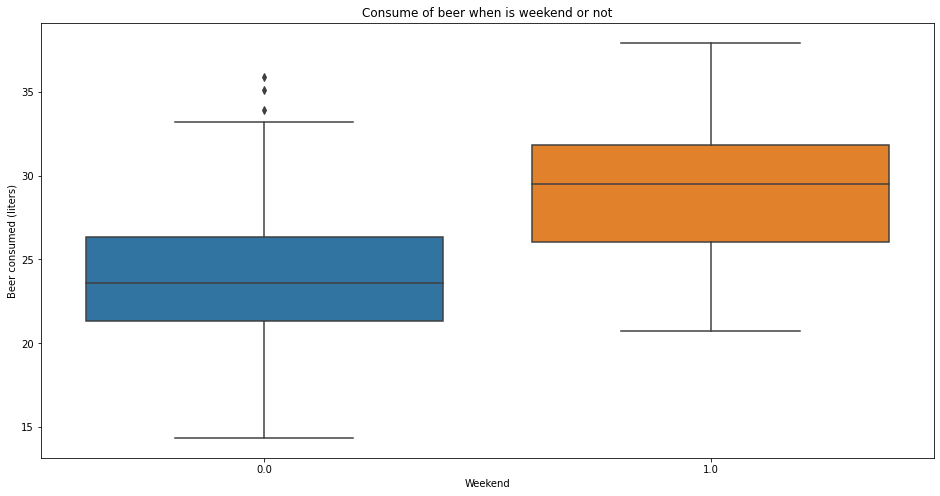

In [603]:
plt.figure(figsize=(16,8))
sns.boxplot(x=sp_beer['Weekend'], y=sp_beer['Beer consumed (liters)'])
plt.title('Consume of beer when is weekend or not')
plt.show()
#Here we see that in weekends the consume is greater

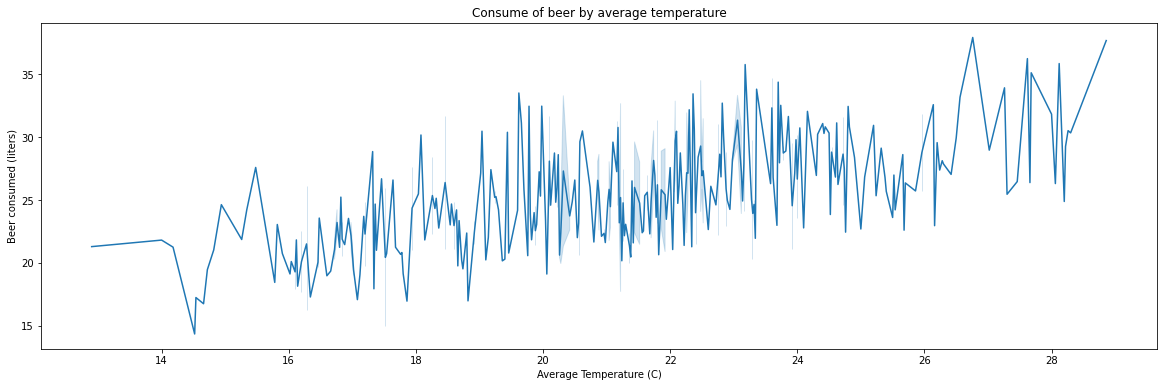

In [602]:
plt.figure(figsize=(20, 6))
sns.lineplot(x=sp_beer['Average Temperature (C)'], y=sp_beer['Beer consumed (liters)'])
plt.title('Consume of beer by average temperature')
plt.show()
# With this whe can see that temperature raises with the consume of beer

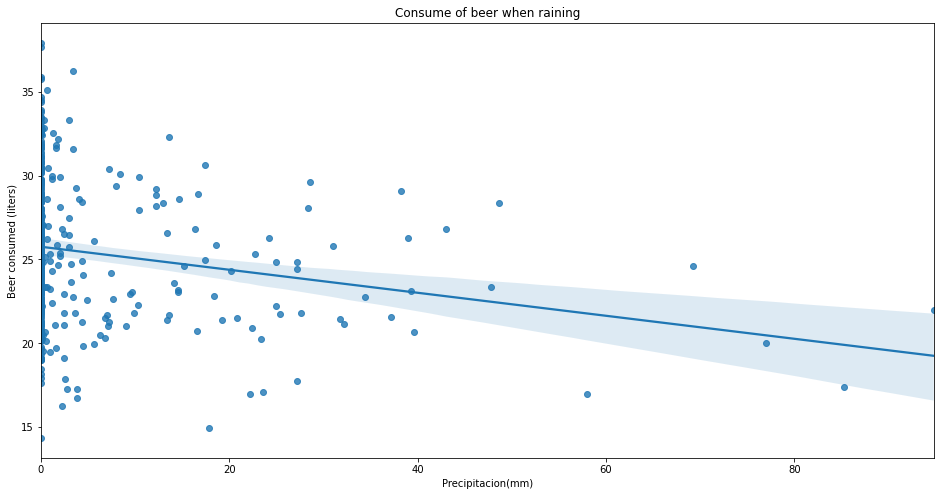

In [601]:
plt.figure(figsize=(16,8))
sns.regplot(x=sp_beer['Precipitacion(mm)'], y=sp_beer['Beer consumed (liters)'])
plt.title('Consume of beer when raining')
plt.show()

 find the best  Pearson Correlation to create a model 

In [277]:
sp_beer.corr().round(3)
# Max Temperature has the best correlation with beer consume

,Average Temperature (C),Min Temperature (C),Max Temperature (C),Precipitacion(mm),Weekend,Beer consumed (liters),Month
Average Temperature (C),1.000,0.863,0.923,0.024,-0.051,0.575,-0.103
Min Temperature (C),0.863,1.000,0.673,0.099,-0.060,0.393,-0.173
Max Temperature (C),0.923,0.673,1.000,-0.049,-0.040,0.643,-0.075
Precipitacion(mm),0.024,0.099,-0.049,1.000,0.002,-0.194,0.007
Weekend,-0.051,-0.060,-0.040,0.002,1.000,0.506,-0.007
Beer consumed (liters),0.575,0.393,0.643,-0.194,0.506,1.000,0.040
Month,-0.103,-0.173,-0.075,0.007,-0.007,0.040,1.000


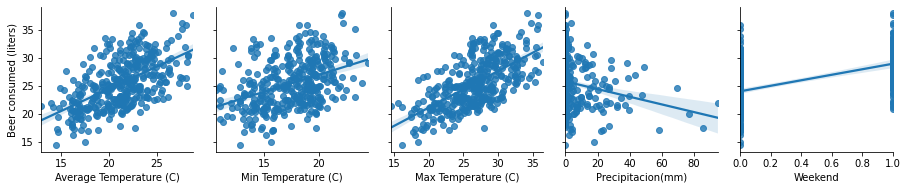

In [280]:
sns.pairplot(sp_beer, y_vars = 'Beer consumed (liters)', 
             x_vars = ['Average Temperature (C)', 'Min Temperature (C)', 'Max Temperature (C)', 'Precipitacion(mm)', 'Weekend'],
             kind='reg')
plt.show()
# the data gets better aggregated in the third graph and with a better regression line but preciptation could be usefull too

### Model creation and evaluation

Split the dataset into training and testing set and build a model to predict the consume of beer

In [284]:
X = sp_beer[['Max Temperature (C)', 'Weekend']]
y = sp_beer['Beer consumed (liters)']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6, random_state=1)

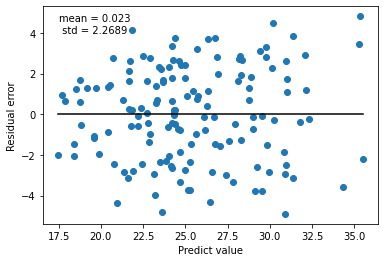

In [285]:
LR = LinearRegression()
LR.fit(X_train, y_train)
yhat = LR.predict(X_test)
residual = yhat - y_test
avgresidual = round(np.mean(residual),4)
stdresidual = round(np.std(residual),4)
plt.figure(1)
plt.scatter(yhat,residual)
plt.plot([min(yhat),max(yhat)],[avgresidual,avgresidual],linestyle='-',c='black')
plt.xlabel('Predict value')
plt.ylabel('Residual error')
plt.text(17.5,4,'mean = {} \n std = {}'.format(avgresidual,stdresidual))
plt.show()

In [291]:
R2 = r2_score(y_test, yhat)
print('R2 score: {}'.format(R2))
print('MSE value: {}' .format(mean_squared_error(y_test,yhat)))
print('adjusted R2 score: {}'.format(1-(1-R2)*(365-1)/(365-2-1)))
# that model gives us a good adjusted R² score and a lower MSE value

R2 score: 0.73965219067442
MSE value: 5.148389877174436
adjusted R2 score: 0.7382138049875384


## RESULTS AND DISCUSSION

The data analysis from Foursquare API provided us understandable vision about the geographicalition and type of venues that can sell any alcoholic beverages and, with that, fight to conquer possible clients in that neighborhood. And with that we could perceive that Rio Pequeno would be a better place to start that sort of store (image 1), when take to mind about competition, but for a matter of contrast the Jardim Everest is located in the neighborhood called as Jardins in the South side of São Paulo. That place has the most expensive square meter in all the city except when compared to the Paulista avenue and the same borough accommodate the greater concentration of venues that sell drinks and beer. Another thing that could be noticed was that the students tend to spend more money with beer in hot (image 2) and dry (image 3) days and mainly during the end of the year and in january and february (image 4), when it's summer season. Besides that, analyzing the image 5 we can perceive that in weekends consume of beer are greater, but the blue box plot has some outliers and that can happen on account of holidays that falls in days of week. With all that information we could create a cluster and a linear regression model to predict possible beer selling outcomes. The linear regression model has a 0.74 R² score and after settling our business for some time, that model could be easily adjusted to be get a finer adaptation and better predictions.

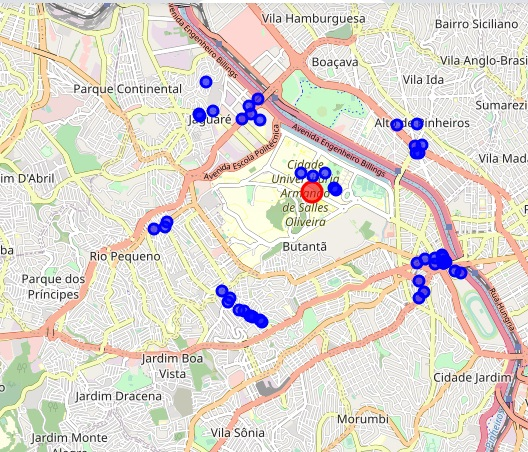

In [620]:
Image(filename='5.jpg',width=800, height=100)
# Image 1

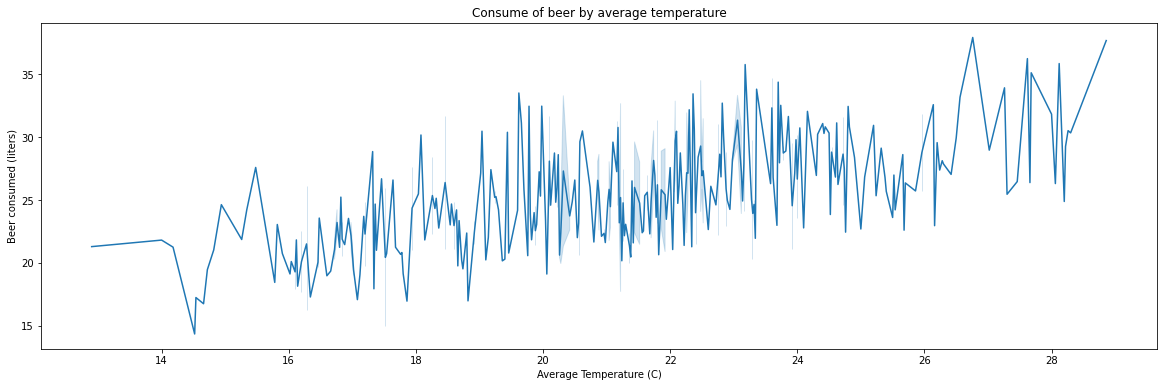

In [621]:
Image(filename='3.png',width=800, height=400)
# Image 2

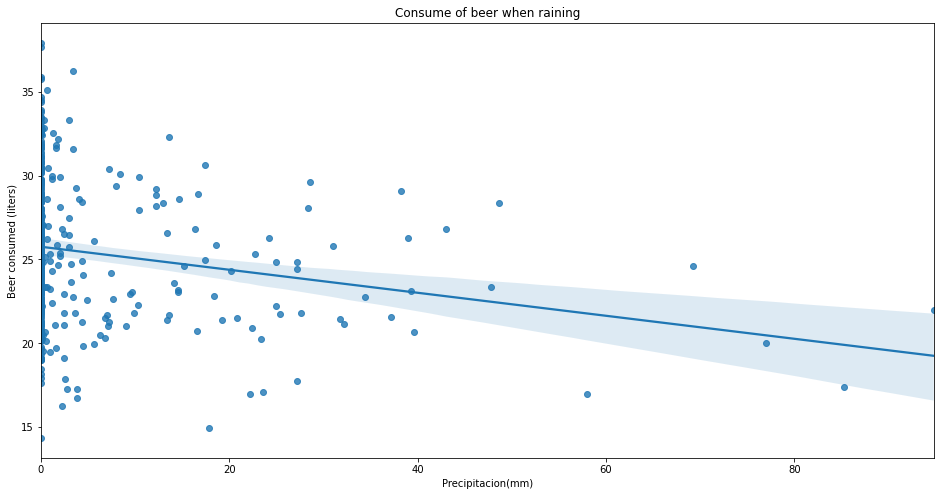

In [622]:
Image(filename='4.png',width=800, height=400)
# Image 3

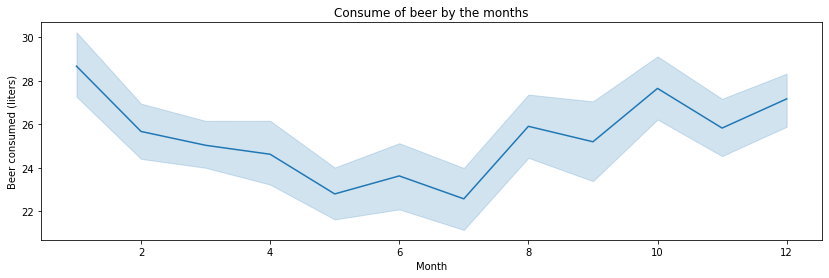

In [619]:
Image(filename='1.png',width=800, height=400)
# Image 4

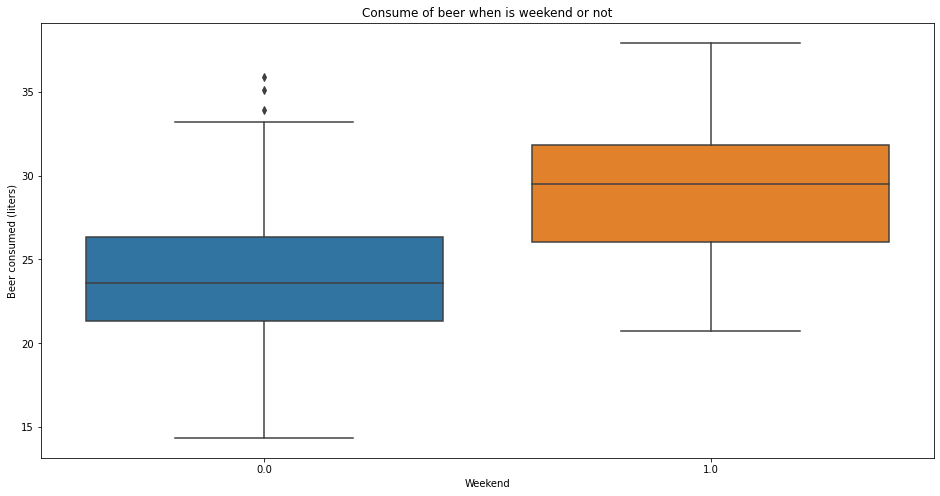

In [618]:
Image(filename='2.png',width=800, height=400)
# Image 5

## CONCLUSION

We analysed several types of data and could determine the better place surrounding the University of São Paulo, and also the best months, time conditions and We analysed several types of data and could determine the better place surrounding the University of São Paulo, and also the best months e time conditions to sell our product. The stakeholders should take to mind costs about buying or renting a local, legal and sanitary questions when the time to take the plan to action. Maybe further investigation on that fields should be advided.  

# REFERENCES 

1. https://ourworldindata.org/alcohol-consumption#:~:text=consumption%20per%20person-,Alcohol%20consumption%20across%20the%20world%20today,of%20pure%20alcohol%20per%20year.
2. https://www.kirinholdings.co.jp/english/news/2019/1224_01.html
3. https://www.kaggle.com/dongeorge/beer-consumption-sao-paulo
4. https://www.statista.com/outlook/10010000/115/beer/brazil#market-arpu